# Reminder to startup the Unity render binary if it is not already running!

In [50]:
import sys
import numpy as np
import matplotlib.pyplot as plt

class RRT_star_Node:
    def __init__(self, pos):
        self.pos = pos
        self.cost = 0
        self.edges = np.array([])
        self.parent = None

class RRT_star_Graph:
    def __init__(self, nodes=np.array([]), obstacles=np.array([[]])):
        self.nodes = nodes
        self.obstacles = obstacles # format: np.array([[x_center, y_center, radius], [...], etc.])
    def add_node(self, node):
        self.nodes = np.append(self.nodes, node)
    def add_edge(self, node1, node2):
        node1.edges = np.append(node1.edges, node2)
        node2.edges = np.append(node2.edges, node1)
    def remove_edge(self, node1, node2):
        node1.edges = np.delete(node1.edges, np.argwhere(node1.edges == node2))
        node2.edges = np.delete(node2.edges, np.argwhere(node2.edges == node1))
        
    def nearest_node(self, v):
        dist = None
        nearest = None
        for node in self.nodes:
            node_dist = np.linalg.norm(v - node.pos)
            if dist is None or node_dist < dist:
                dist = node_dist
                nearest = node
        return nearest

    # Dijkstra
    def shortest_path_parents(self, source):
        visited = {}
        dist = {}
        parent = {}
        for n in self.nodes:
            visited[n] = False
            parent[n] = None
            dist[n] = [sys.maxsize]
        
        dist[source] = 0
        queue = [source]
        while queue:
            curr = queue.pop(0)
            for n in curr.edges:
                if not visited[n]:
                    queue.append(n)
                    new_dist = dist[curr] + np.linalg.norm(curr.pos - n.pos)
                    if dist[n] > new_dist:
                        parent[n] = curr
                        dist[n] = new_dist
            visited[curr] = True
            
        # helper, assumes the parent exists
        return parent
    
    def line_collides(self, p1, p2):
        for obstacle in self.obstacles:
            center = obstacle[:2]
            radius = obstacle[2]

            rel_p1 = p1 - center
            rel_p2 = p2 - center
            
            a = np.dot(rel_p2 - rel_p1, rel_p2 - rel_p1)
            b = 2 * np.dot(rel_p1, rel_p2 - rel_p1)
            c = np.dot(rel_p1, rel_p1) - radius * radius

            discrim = b * b - 4 * a * c
            if discrim <= 0: # no intersection
                continue
            t1 = (-b + np.sqrt(discrim)) / (2 * a);
            t2 = (-b - np.sqrt(discrim)) / (2 * a);

            if (t1 >= 0 and t1 <= 1) or (t2 >= 0 and t2 <= 1):
                return True

        return False
    
    # goes up the parent chain up to source
    def get_path(self, parent, curr, path):
        if parent[curr]:
            path = self.get_path(parent, parent[curr], path)
        path = np.append(path, curr)
        return path

In [51]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    else:
        return v / norm

In [62]:
# 0 1 hypercube.
DELTA = 0.1
TRIALS = 800
DIM = 3
SEARCH_RADIUS = 2.5 * (np.log(TRIALS) / TRIALS)**(1/DIM)

start_pos = np.array([0, 0, 1.])
end_pos = np.array([0.5, -0.5, 1.])

bound_start = np.array([-0.5, -0.5, 1])
bound_end = np.array([0.5, 0.5, 1])

start_node = RRT_star_Node(start_pos)
graph = RRT_star_Graph(np.array([start_node]),
                       np.array([[0.1, 0.1, 0.04], [0.1, -0.1, 0.1], [-0.3, -0.3, 0.07]]))


for _ in range(TRIALS):
    rand_pos = bound_start + (bound_end - bound_start) * [np.random.random_sample(),
                                                          np.random.random_sample(),
                                                          np.random.random_sample()]
    nearest_node = graph.nearest_node(rand_pos)
    
    dir_norm = normalize(rand_pos - nearest_node.pos)
    new_node = RRT_star_Node(nearest_node.pos + DELTA * dir_norm)
    new_node.cost = nearest_node.cost + np.linalg.norm(nearest_node.pos - new_node.pos)

    if not graph.line_collides(nearest_node.pos[:2], new_node.pos[:2]):
        final_neighbor = nearest_node # tentative assignment
        for node in graph.nodes:
            if np.linalg.norm(node.pos - new_node.pos) < SEARCH_RADIUS:
                agg_cost = node.cost + np.linalg.norm(node.pos - new_node.pos)
                if agg_cost < new_node.cost and not graph.line_collides(new_node.pos[:2], node.pos[:2]):
                    new_node.cost = agg_cost
                    final_neighbor = node

        for node in graph.nodes:
            if np.linalg.norm(node.pos - new_node.pos) < SEARCH_RADIUS:
                agg_cost = new_node.cost + np.linalg.norm(node.pos - new_node.pos)
                if agg_cost < node.cost and not graph.line_collides(new_node.pos[:2], node.pos[:2]):
                    if node.parent:
                        graph.remove_edge(node, node.parent)
                    node.cost = agg_cost
                    for n in node.edges:
                        n.cost = node.cost + np.linalg.norm(node.pos - n.pos)
                    node.parent = new_node
                    graph.add_edge(new_node, node)

        graph.add_node(new_node)
        new_node.parent = final_neighbor
        graph.add_edge(final_neighbor, new_node)
    
parent = graph.shortest_path_parents(start_node)
nearest_node = graph.nearest_node(end_pos)
path = graph.get_path(parent, nearest_node, np.array([]))

path = np.append(path, RRT_star_Node(end_pos))

[0. 0. 1.]
[-0.0111158  -0.12634238  1.        ]
[ 0.00361833 -0.1616917   1.        ]
[ 0.32349798 -0.36596016  1.        ]
[ 0.48776466 -0.46892448  1.        ]
[ 0.5 -0.5  1. ]


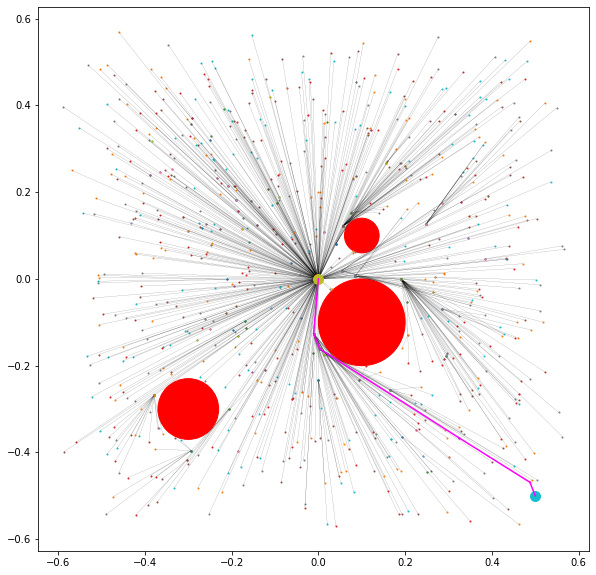

In [63]:
tree = plt.figure()
for obstacle in graph.obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='r', figure = tree)
    plt.gca().add_patch(circle)

for node in graph.nodes:
    if node.parent:
        n = node.parent
        
        xx, yy = [n.pos[0], node.pos[0]], [n.pos[1], node.pos[1]]
        plt.plot(n.pos[0], n.pos[1], marker='.', markersize=2)
        plt.plot(node.pos[0], node.pos[1], marker='.', markersize=2)
        plt.plot(xx, yy, 'k-', linewidth=0.1, figure = tree)

plt.plot(start_node.pos[0], start_node.pos[1], marker='.', markersize=20)
plt.plot(end_pos[0], end_pos[1], '.', markersize=20)


prev_node = start_node
for node in path:
    xx, yy = [prev_node.pos[0], node.pos[0]], [prev_node.pos[1], node.pos[1]]
    plt.plot(xx, yy, color='fuchsia', figure = tree)
    prev_node = node
    print(node.pos)

plt.gca().set_aspect('equal')
tree.set_size_inches(10, 10)

[[  0.          -2.86639265 -30.        ]
 [  0.51724138  -2.82510858 -30.        ]
 [  1.03448276  -2.87128522 -30.        ]
 [  1.55172414  -2.9987383  -30.        ]
 [  2.06896552  -3.20128359 -30.        ]
 [  2.5862069   -3.47273682 -30.        ]
 [  3.10344828  -3.80691375 -30.        ]
 [  3.62068966  -4.19763013 -30.        ]
 [  4.13793103  -4.6387017  -30.        ]
 [  4.65517241  -5.12394423 -30.        ]
 [  5.17241379  -5.64717345 -30.        ]
 [  5.68965517  -6.20220511 -30.        ]
 [  6.20689655  -6.78285498 -30.        ]
 [  6.72413793  -7.38293879 -30.        ]
 [  7.24137931  -7.99627229 -30.        ]
 [  7.75862069  -8.61667124 -30.        ]
 [  8.27586207  -9.23795138 -30.        ]
 [  8.79310345  -9.85392847 -30.        ]
 [  9.31034483 -10.45841825 -30.        ]
 [  9.82758621 -11.04523647 -30.        ]
 [ 10.34482759 -11.60819889 -30.        ]
 [ 10.86206897 -12.14112125 -30.        ]
 [ 11.37931034 -12.6378193  -30.        ]
 [ 11.89655172 -13.09210879 -30.  

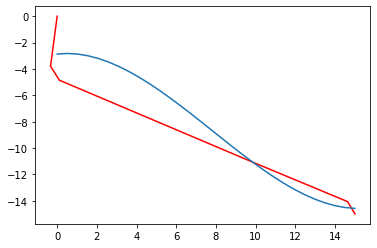

In [123]:
# There is some kind of positive relation btwn AMBITION and EPSILON;
# the more ambitious, the greater the need for leeway. 
AMBITION = 2.
EPSILON = 1.

# string = "with half-width {}, center at {}, num_waypoints {}, epsilon {:.2}, & AMBITION {:.2}...".format(
#     half_width, center, num_waypoints, EPSILON, AMBITION)

# can do arctan2 + np.pi/2 for eahc
theta = 0

theta_perpen = theta + np.pi / 2
# waypoint_coords = np.vstack((center[0] + (half_width * np.cos(theta)) / (1 + np.sin(theta) * np.sin(theta)), #x
#                              center[1] + (half_width * np.sin(theta) * np.cos(theta)) / (1 + np.sin(theta) * np.sin(theta)), #y
#                              center[2] * np.ones(num_waypoints), #z
#                              theta_perpen))

SCALER = np.array([30., 30., -30.])

scaled_path = np.empty((0,3))
for waypoint_node in path:
    scaled_path = np.vstack([scaled_path, np.multiply(waypoint_node.pos, SCALER)])

start_pos = scaled_path[0]
end_pos = scaled_path[-1]
DEGREE = 3
fit_coefs = np.polynomial.polynomial.polyfit(scaled_path[:,0], scaled_path[:,1], DEGREE)

# print(fit_coefs)

num_waypoints = 30
x_pts = np.linspace(start_pos[0], end_pos[0], num_waypoints)

def y_res(x):
    out = 0
    for deg in range(fit_coefs.size):
        out += fit_coefs[deg] * x**(deg)
    return out

y_pts = y_res(x_pts)

fit = plt.figure()
plt.plot(scaled_path[:,0], scaled_path[:,1], 'r', figure=fit)
plt.plot(x_pts, y_pts, figure=fit)

waypoint_coords = np.vstack((x_pts,
                             y_pts,
                             -30 * np.ones(num_waypoints))).T

print(waypoint_coords)

In [124]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
%reload_ext autoreload
%autoreload 

from IPython.display import HTML, display
sys.path.insert(0, '../')
from flightgoggles.env import *

if __name__ == "__main__":
    # drone flips over when going too fast ? ? ? SimSpeed adjustment needed??
    env = flightgoggles_env(
        cfg_dir="../config",
        cfg_fgclient="FlightGogglesClient_testing.yaml",
        cfg_uav="multicopterDynamicsSimSpeed.yaml") # 30 max_speed/accel multicopterDynamicsSimSpeed
    env.set_state_vehicle(vehicle_id="uav1", 
                          position = start_pos,
                          attitude_euler_angle=np.array([0., 0., 0.]))
    curr_pos = env.get_state("uav1")["position"]
    curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
    curr_vel = env.get_state("uav1")["velocity"]

    fol_accumulator = None
    pos_accumulator = np.array([curr_pos])
    per_accumulator = None
    
    rand_accumulator = None
    
    curr_waypoint = start_pos
    
    time_counter = 0
    crash = False
    for waypoint in waypoint_coords:
        # waypoint = np.append(waypoint_node.pos, np.arctan2(waypoint_node.pos[1], waypoint_node.pos[0]) + np.pi / 2) 
        
        prev_waypoint = curr_waypoint
        curr_waypoint = waypoint
        
        if (np.array_equal(curr_waypoint[:3], end_pos)):
            target_pose = curr_waypoint
            EPSILON = 0.1
                
        while np.linalg.norm(curr_pos - curr_waypoint[:3]) >= EPSILON:
            time_counter += 0.01
            curr_pos = env.get_state("uav1")["position"]
            curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
            curr_vel = env.get_state("uav1")["velocity"]
            
            # clean solution from: https://stackoverflow.com/questions/31273991/
            d = curr_waypoint[:3] - prev_waypoint[:3]
            t = -np.dot(prev_waypoint[:3] - curr_pos, d) / np.linalg.norm(d)**2
            # 2d only for now
            curr_pos_perpend = prev_waypoint[:3] + (d)*t
            
            if not (np.array_equal(curr_waypoint[:3], end_pos)):
                target_pose = (curr_pos_perpend + normalize(curr_waypoint[:3] - curr_pos_perpend) * AMBITION)
                # curr_att considers x=0 as pi/2
                att_to_target = np.arctan2(target_pose[1] - curr_pos[1],
                                           target_pose[0] - curr_pos[0])
                
                # HOW TO CHANGE THIS?
                target_pose = np.append(target_pose, att_to_target) # attitude
                
                rand_accumulator = np.append(rand_accumulator, target_pose[3])
                
                if fol_accumulator is None:
                    fol_accumulator = np.array([target_pose])
                else:
                    fol_accumulator = np.vstack((fol_accumulator, target_pose))

            collided = env.proceed_waypoint(vehicle_id="uav1",
                                            waypoint_command=target_pose,
                                            duration=0.01)
    
    
            if per_accumulator is None:
                per_accumulator = np.array([curr_pos_perpend])
            else:
                per_accumulator = np.vstack((per_accumulator, curr_pos_perpend))
    
            pos_accumulator = np.vstack((pos_accumulator, curr_pos))
            if collided:
                crash = True
                break
        if crash:
            print("CRASHED! :(")
            break
    
#     f = open("observation notes continuous point lemniscate.txt", "a")
#     if not crash:
#         f.write(string + " it took {:.2f} sec\n".format(time_counter))
#     else:
#         f.write(string + " it crashed :(\n")
#     f.close()
    
    with np.printoptions(precision=2, suppress=True):
        print("Final pose", np.append(env.get_state("uav1")["position"],
                                      env.get_state("uav1")["attitude_euler_angle"][2]))
        
    ani_set = env.plot_state_video(flag_save=False, filename="uav", dpi=200)
    if "cam1" in ani_set.keys():
        display(HTML(ani_set["cam1"].to_html5_video()))
    env.close()











Final pose [ 14.07 -14.52 -30.    -0.22]


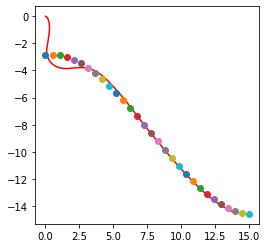

In [125]:
# Orange dots are the waypoints, dotted are waypoints
# coloration suggests the order
import itertools
import matplotlib.pyplot as plt

plt.gca().set_aspect('equal', adjustable='box')
# plt.plot(fol_accumulator.T[0], fol_accumulator.T[1], '.')
plt.plot(pos_accumulator.T[0], pos_accumulator.T[1], 'r')
# plt.plot(per_accumulator.T[0], per_accumulator.T[1], 'g')
for waypoint in waypoint_coords:
    plt.plot(waypoint[0], waypoint[1], 'o')